In [5]:
import sys
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

from src.config import TRAIN_ANNOTATIONS_JSON, VAL_ANNOTATIONS_JSON, FIGURES_DIR
from src.dataset import load_category_mappings, create_segmentation_mask


In [6]:
def load_annotations(ann_file):
    with open(ann_file, "r") as f:
        dataset = json.load(f)

    coco = COCO(ann_file)
    category_mappings = load_category_mappings(ann_file)
    image_data = []

    for img in dataset["images"]:
        img_id = img["id"]
        img_pixels = img["height"] * img["width"]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = create_segmentation_mask(
            coco, img_id, img["height"], img["width"], category_mappings
        )
        total_foreground_pixels = np.count_nonzero(mask)
        if total_foreground_pixels <= 0:
            print(f"NEG or ZERO MASK: {img_id}")

        for ann in anns:
            cat_id = ann["category_id"]
            cat_name = coco.cats[cat_id]["name"]
            fg_pixels = ann.get("area", 0)

            image_data.append(
                {
                    "image_id": img_id,
                    "image_label": img["file_name"],
                    "category_id": cat_id,
                    "category_name": cat_name,
                    "category_pixels": fg_pixels,
                    "foreground_pixels": total_foreground_pixels,
                    "image_pixels": img_pixels,
                    "fg_area_ratio": fg_pixels / img_pixels if img_pixels > 0 else 0,
                    "total_area_ratio": total_foreground_pixels / img_pixels
                    if img_pixels > 0
                    else 0,
                }
            )

    return pd.DataFrame(image_data)

train_df = load_annotations(TRAIN_ANNOTATIONS_JSON)
val_df = load_annotations(VAL_ANNOTATIONS_JSON)

dataset_df = pd.concat([train_df, val_df], ignore_index=True)

dataset_df.head()

loading annotations into memory...
Done (t=3.57s)
creating index...
index created!
NEG or ZERO MASK: 1870
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


,image_id,image_label,category_id,category_name,category_pixels,foreground_pixels,image_pixels,fg_area_ratio,total_area_ratio
0,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,23,shoe,21618,143007,1048576,0.020617,0.136382
1,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,23,shoe,25257,143007,1048576,0.024087,0.136382
2,16145,6ce91b2c047f7f441edd5dc17326ae17.jpg,7,shorts,96132,143007,1048576,0.091679,0.136382
3,12446,da3618863549ca1db90583f33d1d0664.jpg,14,hat,28104,212154,698368,0.040242,0.303785
4,12446,da3618863549ca1db90583f33d1d0664.jpg,33,neckline,1772,212154,698368,0.002537,0.303785


## Counting the number of images per label

In [23]:
main_item_names = [
    "shirt, blouse",
    "top, t-shirt, sweatshirt",
    "sweater",
    "cardigan",
    "jacket",
    "vest",
    "pants",
    "shorts",
    "skirt",
    "coat",
    "dress",
    "jumpsuit",
    "cape",
    "glasses",
    "hat",
    "headband, head covering, hair accessory",
    "tie",
    "glove",
    "watch",
    "belt",
    "leg warmer",
    "tights, stockings",
    "sock",
    "shoe",
    "bag, wallet",
    "scarf",
    "umbrella",
]

count_df = (
    dataset_df.groupby(["category_id", "category_name"])["image_id"]
    .apply(list)
    .reset_index(name="occurrence")
)

count_df["image_count"] = count_df["occurrence"].apply(len)

count_df["label_count"] = count_df["occurrence"].apply(lambda x: len(set(x)))

count_df = count_df[count_df["category_name"].isin(main_item_names)]

count_df.head()

,category_id,category_name,occurrence,image_count,label_count
0,0,"shirt, blouse","[17264, 17672, 9459, 16375, 9661, 16113, 20165...",6263,6217
1,1,"top, t-shirt, sweatshirt","[12446, 17107, 9459, 9446, 13028, 16265, 19980...",17025,16639
2,2,sweater,"[12069, 19711, 17338, 12970, 10830, 10723, 169...",1515,1506
3,3,cardigan,"[18278, 14772, 17513, 12748, 15584, 13227, 166...",1119,1113
4,4,jacket,"[17672, 9459, 9446, 13028, 9661, 15671, 10431,...",8016,7921


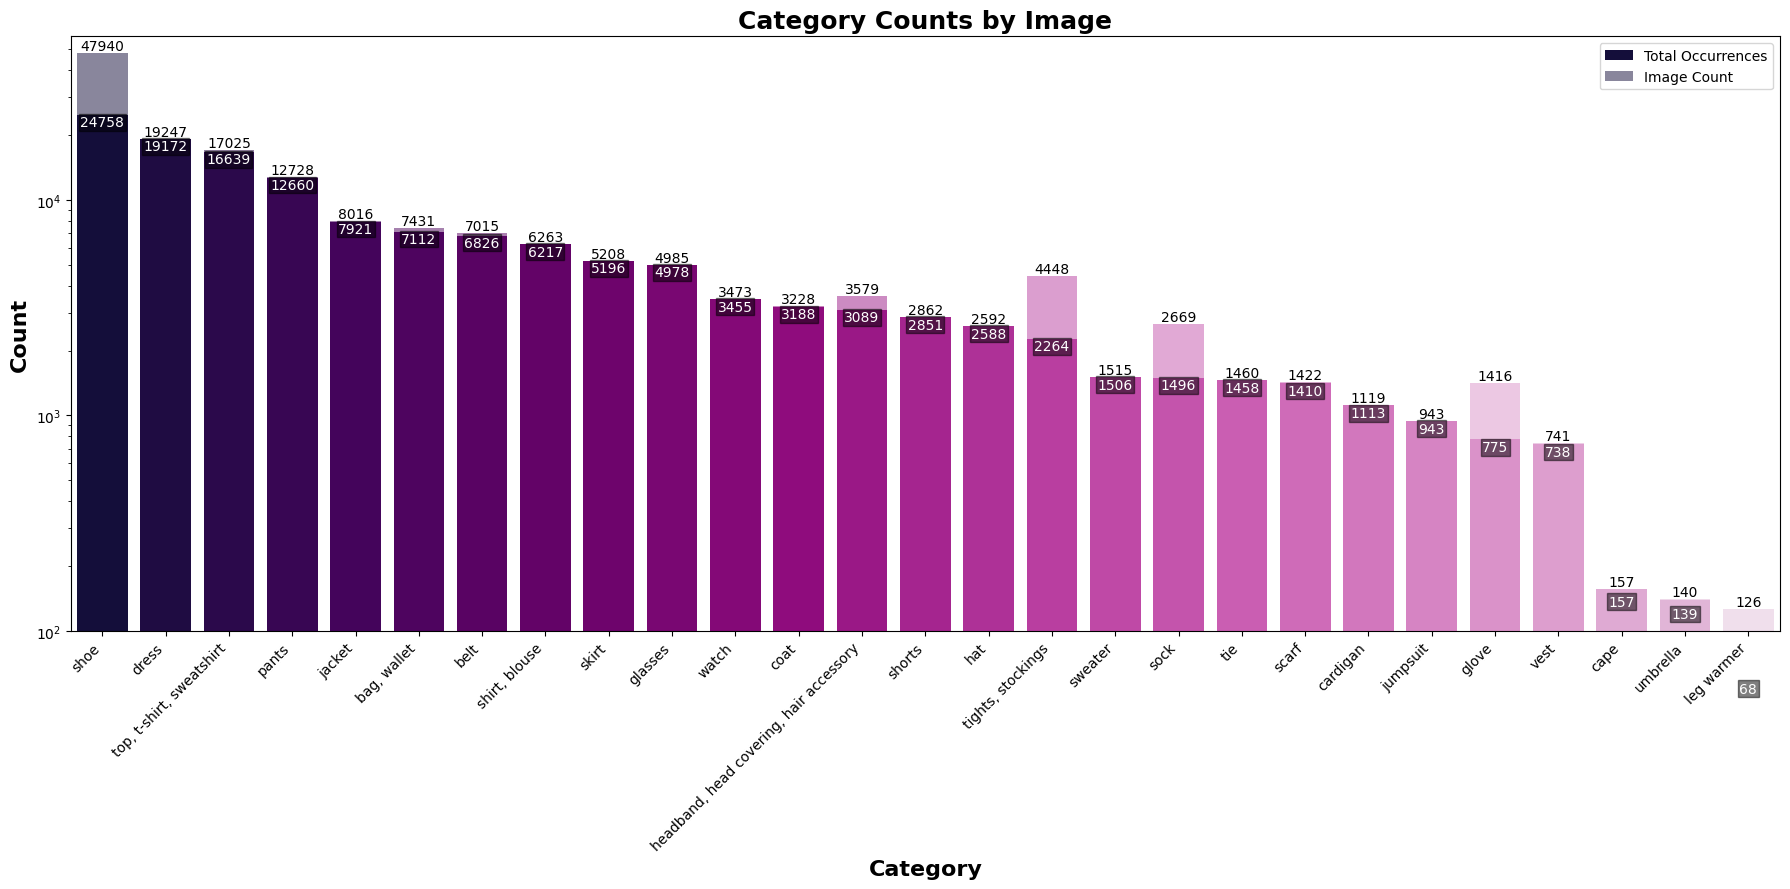

In [ ]:
cmap = load_cmap("Flash", cmap_type="continuous", reverse=True)

num_categories = len(count_df)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

sorted_stats = count_df.sort_values("label_count", ascending=False)

plt.figure(figsize=(18, 9))

max_label_count = sorted_stats["label_count"].max()
max_image_count = sorted_stats["image_count"].max()
max_count = max(max_label_count, max_image_count)

plt.ylim(100, max_count * 1.2)

bars1 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["label_count"],
    color=colors,
    label="Total Occurrences",
)

bars2 = plt.bar(
    range(len(sorted_stats)),
    sorted_stats["image_count"],
    alpha=0.5,
    color=colors,
    label="Image Count",
)

plt.xticks(
    range(len(sorted_stats)), sorted_stats["category_name"], rotation=45, ha="right"
)

plt.xlabel("Category", fontsize=16, fontweight="bold")
plt.ylabel("Count", fontsize=16, fontweight="bold")
plt.title("Category Counts by Image", fontsize=18, fontweight="bold")

plt.yscale("log")
plt.xlim(-0.5, len(sorted_stats) - 0.5)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height - 10,
        f"{int(height)}",
        ha="center",
        va="top",
        color="white",
        bbox=dict(facecolor="black", alpha=0.5, pad=1),
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom')
    
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_counts_by_image.png")
plt.show()


## Mean and Variance for the Pixel Ratio per Category

In [ ]:
ratio_df = (
    dataset_df.groupby(["category_id", "category_name"])
    .agg(
        area_ratio_mean=("total_area_ratio", "mean"),
        area_ratio_median=("total_area_ratio", "median"),
        area_ratio_stdev=("total_area_ratio", "std"),
        foreground_area_ratio_mean=("fg_area_ratio", "mean"),
        foreground_area_ratio_median=("fg_area_ratio", "median"),
        foreground_area_ratio_stdev=("fg_area_ratio", "std"),
    )
    .reset_index()
)

ratio_df = ratio_df[ratio_df["category_name"].isin(main_item_names)]

ratio_df

,category_id,category_name,area_ratio_mean,area_ratio_median,area_ratio_stdev,foreground_area_ratio_mean,foreground_area_ratio_median,foreground_area_ratio_stdev
0,0,"shirt, blouse",0.231496,0.190352,0.136098,0.093120,0.035904,0.140768
1,1,"top, t-shirt, sweatshirt",0.210955,0.171301,0.141356,0.106995,0.044971,0.149426
2,2,sweater,0.301068,0.267885,0.174348,0.217322,0.128102,0.207131
3,3,cardigan,0.258307,0.198593,0.175112,0.164625,0.074916,0.198394
4,4,jacket,0.221237,0.181508,0.129053,0.133398,0.083535,0.132275
5,5,vest,0.194730,0.163013,0.111950,0.068112,0.037086,0.097492
6,6,pants,0.201914,0.175123,0.109074,0.070919,0.060063,0.068444
7,7,shorts,0.144994,0.115405,0.112012,0.049529,0.024489,0.094227
8,8,skirt,0.174753,0.145344,0.114413,0.086866,0.060649,0.095309
9,9,coat,0.235526,0.201521,0.141646,0.162989,0.113517,0.144889


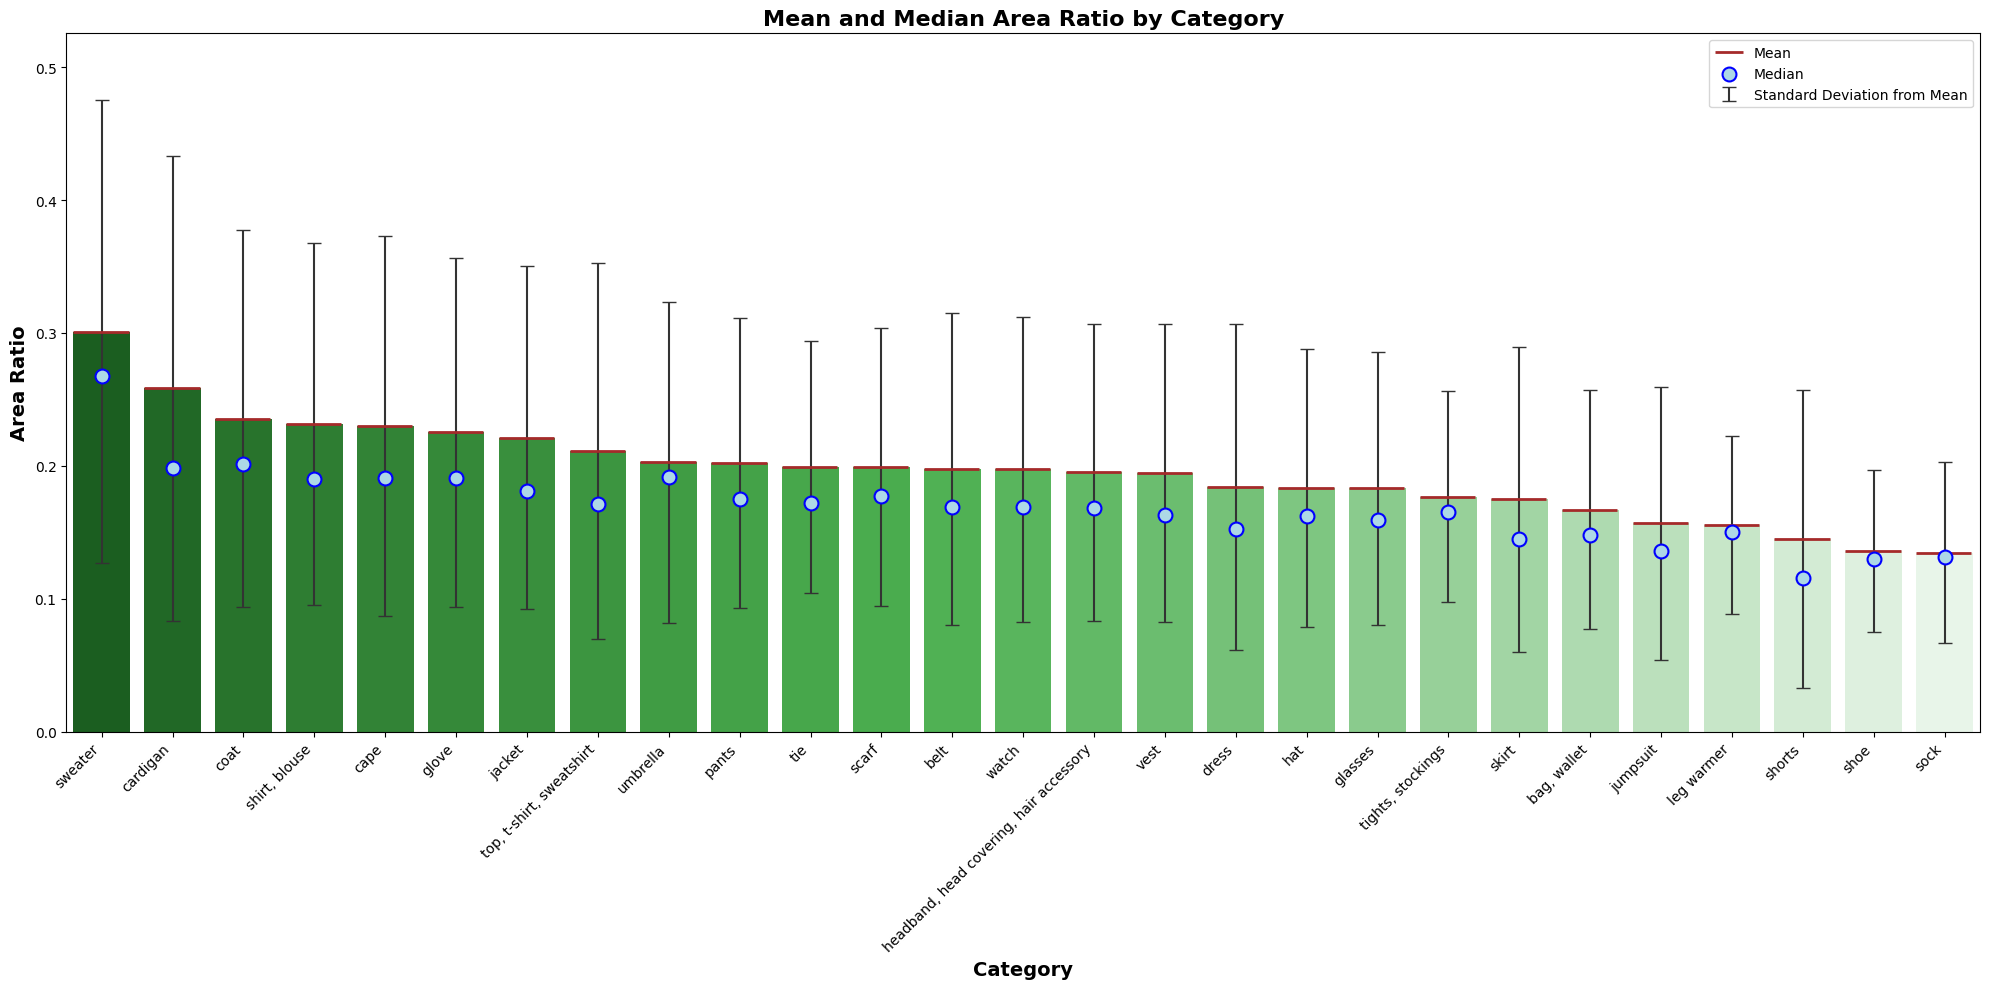

In [61]:
sorted_stats = ratio_df.sort_values("area_ratio_mean", ascending=False)

cmap = load_cmap("green_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8  
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["area_ratio_mean"],
    yerr=sorted_stats["area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["area_ratio_mean"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5) 

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["area_ratio_mean"] + sorted_stats["area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_area_ratio.png")
plt.show()

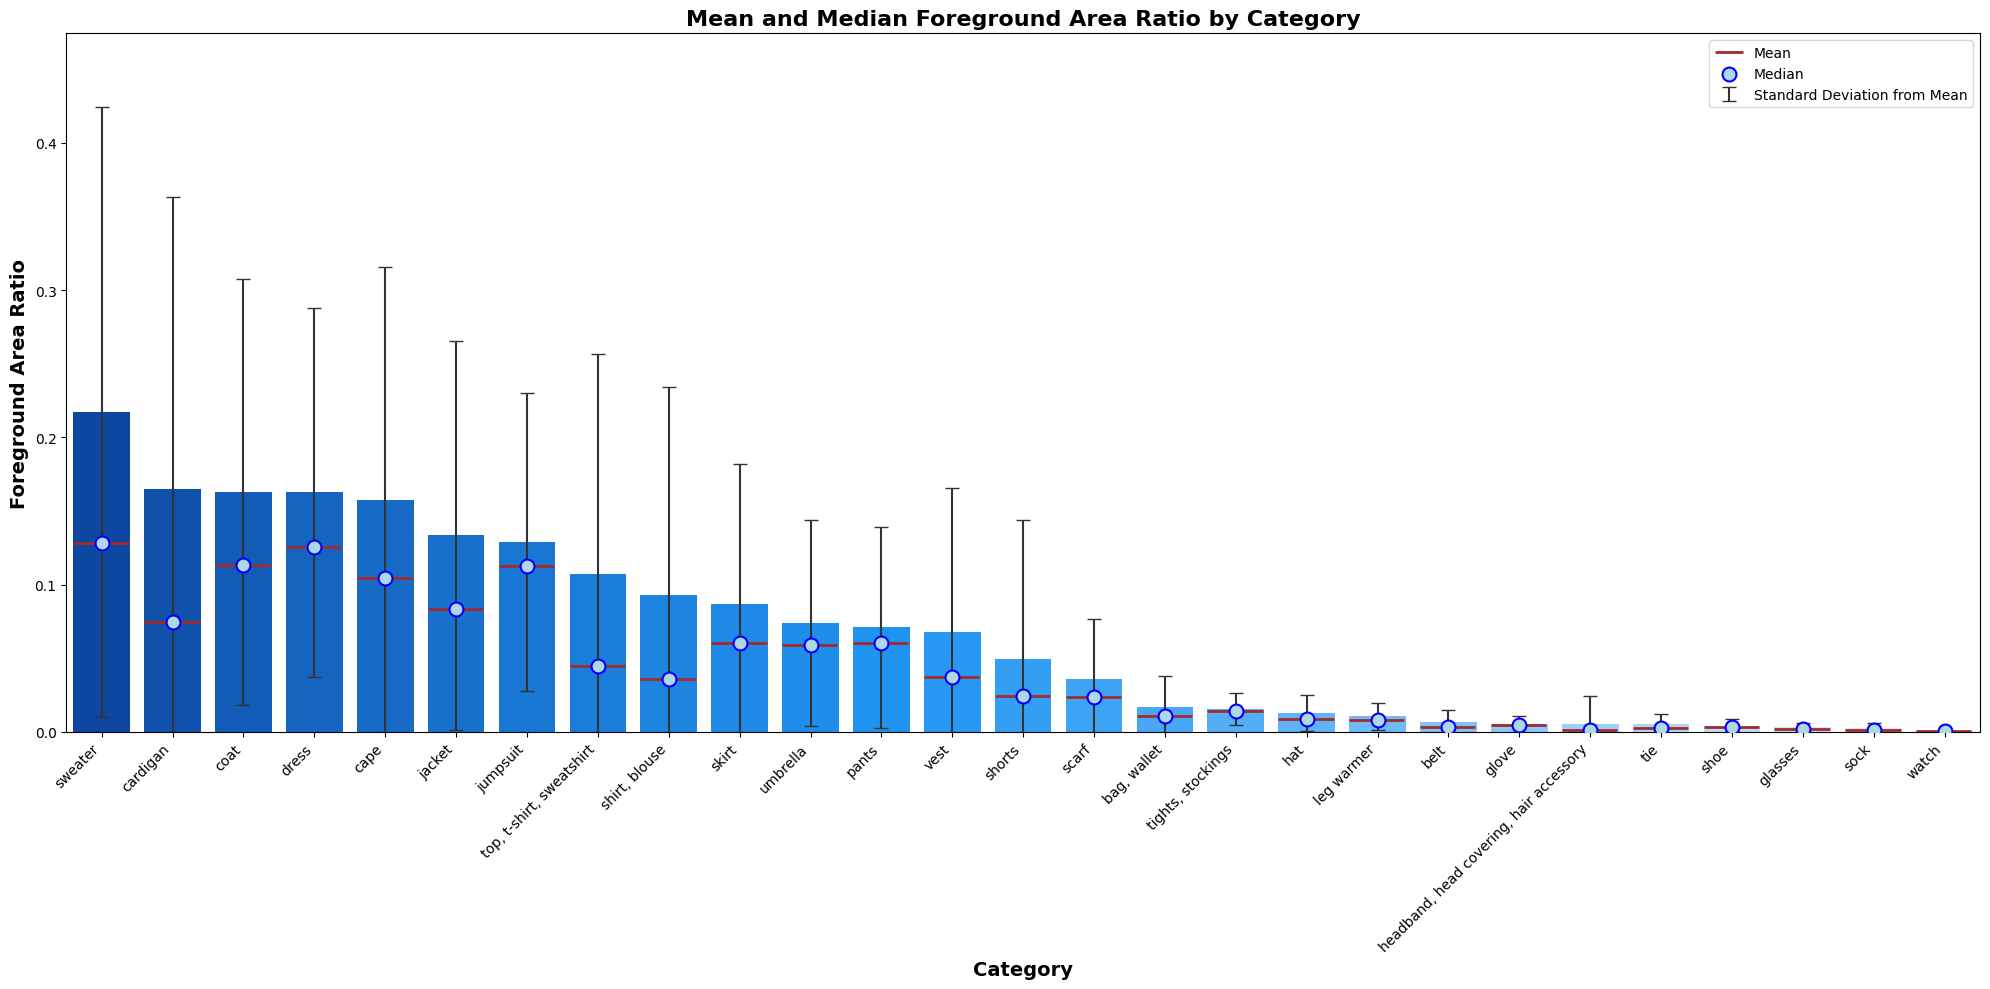

In [62]:
sorted_stats = ratio_df.sort_values(
    "foreground_area_ratio_mean", ascending=False
)

cmap = load_cmap("blue_material", cmap_type="continuous", reverse=True)

num_categories = len(sorted_stats)

color_values = np.linspace(0, 1, num_categories)

colors = [cmap(value) for value in color_values]

plt.figure(figsize=(20, 10))

bar_width = 0.8
x_positions = np.arange(len(sorted_stats))

plt.bar(x_positions, sorted_stats["foreground_area_ratio_mean"], color=colors, width=bar_width)

plt.errorbar(
    x_positions,
    sorted_stats["foreground_area_ratio_mean"],
    yerr=sorted_stats["foreground_area_ratio_stdev"],
    ecolor="#333333",
    capsize=5,
    fmt="none",
    label="Standard Deviation from Mean",
)

plt.hlines(
    y=sorted_stats["foreground_area_ratio_median"],
    xmin=x_positions - 0.4,
    xmax=x_positions + 0.38,
    colors="brown",
    linewidth=2,
    label="Mean",
    zorder=3,
)

plt.xticks(x_positions, sorted_stats["category_name"], rotation=45, ha="right")

plt.xlim(-0.5, len(sorted_stats) - 0.5)

plt.xlabel("Category", fontsize=14, fontweight="bold")
plt.ylabel("Foreground Area Ratio", fontsize=14, fontweight="bold")
plt.title("Mean and Median Foreground Area Ratio by Category", fontsize=16, fontweight="bold")

plt.scatter(
    x_positions,
    sorted_stats["foreground_area_ratio_median"],
    marker="o",
    color="lightblue",
    edgecolor="blue",
    linewidth=1.5,
    s=100,
    zorder=4,
    label="Median",
)

upper_limit = (
    sorted_stats["foreground_area_ratio_mean"]
    + sorted_stats["foreground_area_ratio_stdev"]
).max() + 0.05
plt.ylim(0, upper_limit)

plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "category_foreground_area_ratio.png")
plt.show()